# Multi-Layer Perceptron

  다층 퍼셉트론(multi-layer perceptron, MLP)는 퍼셉트론으로 이루어진 층(layer) 여러 개를 순차적으로 붙여놓은 형태입니다. MLP는 정방향 인공신경망(feed-forward deep neural network, FFDNN)이라고 부르기도 합니다. 입력에 가까운 층을 아래에 있다고 하고, 출력에 가까운 층을 위에 있다고 이야기합니다. 신호는 아래에서 위로 계속 움직입니다. MLP에서는 인접한 층의 퍼셉트론간의 연결은 있어도 같은 층의 퍼셉트론끼리의 연결은 없습니다. 

  각 층은 그래프 구조에서 하나의 노드처럼 동작합니다. 즉, 입력이 들어오면 연산을 한 후 출력을 내보냅니다.
  
  MLP는 층의 갯수(depth)와 각 층의 크기(width)로 결정됩니다.

In [ ]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 

import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다.

from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

import matplotlib.pyplot as plt

## 데이터 불러오기

In [ ]:
bos = load_boston() # 데이터 불러오기

In [ ]:
# bos 내에는 data, feature name 등 다양한 정보를 포함하고 있다.
df = pd.DataFrame(bos.data) # 데이터의 변수를 데이터프레임으로 만들기 
df.columns = bos.feature_names # 데이터 변수명 불러오기
df['Price'] = bos.target # 집 값에 해당하는 타겟 값 불러오기

# 데이터프레임 보여주기
# df.head()는 상위 5줄만 보여준다.
# df.head(10) 괄호 안에 숫자 10을 넣으면 10줄을 보여준다. 
df.head(10) 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [ ]:
"""
** 데이터 변수 설명 **

CRIM: 범죄율
INDUS: 비소매상업지역 면적 비율
NOX: 일산화질소 농도
RM: 주택당 방 수
LSTAT: 인구 중 하위 계층 비율
B: 인구 중 흑인 비율
PTRATIO: 학생/교사 비율
ZN: 25,000 평방피트를 초과 거주지역 비율
CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
AGE: 1940년 이전에 건축된 주택의 비율
RAD: 방사형 고속도로까지의 거리
DIS: 직업센터의 거리
TAX: 재산세율
"""

'\n** 데이터 변수 설명 **\n\nCRIM: 범죄율\nINDUS: 비소매상업지역 면적 비율\nNOX: 일산화질소 농도\nRM: 주택당 방 수\nLSTAT: 인구 중 하위 계층 비율\nB: 인구 중 흑인 비율\nPTRATIO: 학생/교사 비율\nZN: 25,000 평방피트를 초과 거주지역 비율\nCHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0\nAGE: 1940년 이전에 건축된 주택의 비율\nRAD: 방사형 고속도로까지의 거리\nDIS: 직업센터의 거리\nTAX: 재산세율\n'

## 데이터 스케일링(MinMax Scale)

In [ ]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

## 텐서 데이터와 배치 만들기

In [ ]:
## 데이터를 tensor 형태로 변환
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

train data와 test data를 나눈고 각각 tensor형태로 변환한다

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

## 모델 구축

모델은 Regressor로 정의하며 입력층(노드 13개), 2개의 은닉층(50, 30개), 출력층(1개)으로 구성한다. 데이터의 변수는 13개이므로 입력층의 노드는
13개가 되고 출력층은 집 값인 단일 값을 추출하는 것이므로 1개가 된다. 은닉층에 대해서는 실험을 하면서 튜닝할 수 있다.

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x

## 모델, 손실함수, 최적화 방법 선언

In [ ]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7) # weight_decay는 L2 정규화에서의 penalty 정도를 의미한다.

In [ ]:
print(model)

Regressor(
  (fc1): Linear(in_features=13, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## 모델 학습

In [ ]:
loss_ = [] 
n = len(trainloader)
model.train()

for epoch in range(400): # 400 epoch 진행
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, values = data 

        optimizer.zero_grad() # 최적화 초기화
        
        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
 

    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

        
print('Finished Training')

Finished Training


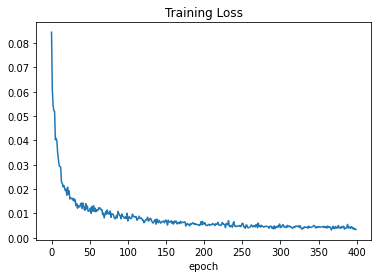

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 모델 평가

In [ ]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float) 
        
    with torch.no_grad():
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # 예측값을 누적
            actual = torch.cat((actual, values), 0) # 실제값을 누적
    1
    predictions = predictions.numpy() # 넘파이 배열로 변경
    actual = actual.numpy() # 넘파이 배열로 변경
    mse = mean_squared_error(predictions, actual) # sklearn을 이용하여 RMSE 계산
    
    return mse  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [ ]:
test_mse = evaluation(testloader) # 시험 데이터의 RMSE
test_rmse = np.sqrt(test_mse)

print("Test MSE: ",test_mse)
print("Test RMSE: ",test_rmse)

Test MSE:  0.0055221296
Test RMSE:  0.07431103
